In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cmath
import datetime
from scipy.linalg import expm

In [3]:
from qutip import Qobj, identity, sigmax, sigmay, sigmaz, tensor
from qutip.qip.algorithms import qft
from qutip import *
#import qutip.logging_utils as logging
#logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
#log_level = logging.INFO
#QuTiP control modules
import qutip.control.pulseoptim as cpo
import qutip.control.pulsegen as pulsegen

example_name = 'QFT'

In [4]:
b  = qutip.Bloch()

#Vizualising Blch sphere
#b.make_sphere()
b.view = [90,0]
b.clear()

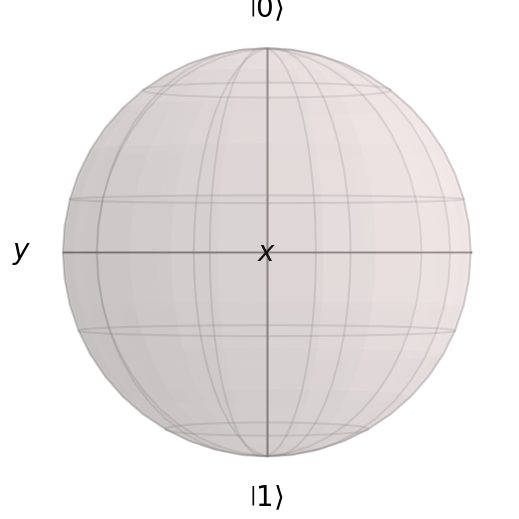

In [5]:

# b.make_sphere()
def plot(rho, num):
    eigenvalues, eigenvectors = np.linalg.eig(rho.full())
    idx = eigenvalues.argsort()[::-1]  # Sort by eigenvalue in descending order
    eigenvectors = eigenvectors[:, idx]  # Sort eigenvectors accordingly
    dominant_eigenvector = eigenvectors[:, 0]
    state = Qobj(dominant_eigenvector / np.linalg.norm(dominant_eigenvector))

    bloch_vector = [
        expect(sigmax(), state),
        expect(sigmay(), state),
        expect(sigmaz(), state)
    ]

    if(num==0):
        state=state.full()
        b.add_points(np.array(bloch_vector)[:, np.newaxis], 'm','c')
        b.render()
    #
    else:
        b.add_states(state)
        b.render()

# b.make_sphere()
rho = Qobj(np.array([[-9,10],[-12,8]]))#this is the input
#plot(rho,0)# if second parameter = 0, it will plot a point, if 1 it will plot a vector
b.show()

In [6]:
# everything is in units of MHz
f_1 = 5.03103*(10**3)
f_2 = 4.92672*(10**3)
f_3 = 5.03648*(10**3)
f_4 = 4.96961*(10**3)
f_5 = 4.83780*(10**3)
f_6 = 4.92466*(10**3)
delta_1 = -271
delta_2 = -269
delta_3 = -268
delta_4 = -269
delta_5 = -280
delta_6 = -271
# all the times (T) are in microseconds. Therefore, 1/T would be in MHz. [NOT INCLUDED rn.]
T1_1 = 44
T1_2 = 30
T1_3 = 25
T1_4 = 37
T1_5 = 1.6
T1_6 = 57
T2star_1 = 35
T2star_2 = 21
T2star_3 = 11
T2star_4 = 28
T2star_5 = 2.2
T2star_6 = 26
T2_1 = 40
T2_2 = 42
T2_3 = 27
T2_4 = 30
T2_5 = 2
T2_6 = 28


In [7]:
# no. of levels for each transmon.
N = 3
f_1 = 5.03103*(10**3)
f_2 = 4.92672*(10**3)
delta_1 = -271
delta_2 = -269
# the lists of variables for all 6 qubits.
f = [f_1, f_2] #the coefficient of the bare hamiltonian for each qubit
delta = [delta_1, delta_2] #the coefficient for the Kerr term
#      11    12     21    22
J = [[ 0.0, 4.03],[4.03, 0.0]]

# defines a_i.
a_1 = tensor(destroy(N), qeye(N))
a_2 = tensor(qeye(N), destroy(N))

a = [a_1, a_2]

# defines the identity matrix
identity_matrix = tensor(qeye(N), qeye(N))
# defines the zero matrix
zero_ = Qobj(np.zeros((N,N)))
zero_matrix = tensor(zero_, zero_)

def Hamiltonian(f, delta, J, N):
    
    # defines the bare Hamiltonian
    H_bare = zero_matrix
    for i in range(2):
        e = (f[i]-f[i])*(Qobj(a[i]).dag()*Qobj(a[i])) + 0.5*delta[i]*(Qobj(a[i]).dag()*Qobj(a[i]))*((Qobj(a[i]).dag()*Qobj(a[i])) - identity_matrix)
        H_bare = H_bare + (2*np.pi)*e
       
    # defines the interaction Hamiltonian (the spins are labelled 0-5)
    H_int = zero_matrix
    for i in range(2):
        # defines the interaction with the next neighbour on the right of the ith spin - which is the ((i+1) mod 6)-th spin..
        p_neighbor_1 = (J[i][(i + 1)%2])*(Qobj(a[i]).dag()*Qobj(a[(i+1)%2]) + Qobj(a[i])*Qobj(a[(i+1)%2]).dag())
        H_int = H_int + 0*(2*np.pi)*0.5*(p_neighbor_1) #to prevent double counting, we need to multiply by 0.5.  
    
    #defines the full Hamiltonian
    Ham = H_bare + H_int
    return Ham

H_d = Hamiltonian(f, delta, J, N)
H_c = [ (2*np.pi)*Qobj(a[0].dag() + a[0])/2,(2*np.pi)*Qobj(a[1].dag() + a[1])/2]
n_ctrls = len(H_c)

# start point for the gate evolution
U_0 = identity_matrix
# Target for the gate evolution - Quantum Fourier Transform gate
from qutip.qip.operations import cnot
U_targ = cnot()#(tensor(identity(2),identity(2))-1j*tensor(sigmaz(),sigmax()))*(1/np.sqrt(2))
H_d


Quantum object: dims=[[3, 3], [3, 3]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[    0.             0.             0.             0.
      0.             0.             0.             0.
      0.        ]
 [    0.             0.             0.             0.
      0.             0.             0.             0.
      0.        ]
 [    0.             0.         -1690.17684763     0.
      0.             0.             0.             0.
      0.        ]
 [    0.             0.             0.             0.
      0.             0.             0.             0.
      0.        ]
 [    0.             0.             0.             0.
      0.             0.             0.             0.
      0.        ]
 [    0.             0.             0.             0.
      0.         -1690.17684763     0.             0.
      0.        ]
 [    0.             0.             0.             0.
      0.             0.         -1702.74321825     0.
      0.        ]
 [    0.       

In [14]:
N=5
f_1 = 5031.03
f_2 = 4926.72
delta_1 = -271
delta_2 = -269
# the lists of variables for all 6 qubits.
f = [f_1, f_2] #the coefficient of the bare hamiltonian for each qubit
delta = [delta_1, delta_2] #the coefficient for the Kerr term
#      11    12     21    22
J = [[ 0.0, 4.03],[4.03, 0.0]]

# defines a_i.
a_1 = tensor(destroy(N), qeye(N))
a_2 = tensor(qeye(N), destroy(N))

a = [a_1, a_2]

# defines the identity matrix
identity_matrix = tensor(qeye(N), qeye(N))
# defines the zero matrix
zero_ = Qobj(np.zeros((N,N)))
zero_matrix = tensor(zero_, zero_)
def Hamiltonian(f, delta, J, N):
    
    # defines the bare Hamiltonian
    H_bare = zero_matrix
    for i in range(2):
        e = (f[i])*(Qobj(a[i]).dag()*Qobj(a[i])) + 0.5*delta[i]*(Qobj(a[i]).dag()*Qobj(a[i]))*((Qobj(a[i]).dag()*Qobj(a[i])) - identity_matrix)
        H_bare = H_bare + (2*np.pi)*e
       
    # defines the interaction Hamiltonian (the spins are labelled 0-5)
    H_int = zero_matrix
    for i in range(2):
        # defines the interaction with the next neighbour on the right of the ith spin - which is the ((i+1) mod 6)-th spin..
        p_neighbor_1 = (J[i][(i + 1)%2])*(Qobj(a[i]).dag()*Qobj(a[(i+1)%2]) + Qobj(a[i])*Qobj(a[(i+1)%2]).dag())
        H_int = H_int + (2*np.pi)*0.5*(p_neighbor_1) #to prevent double counting, we need to multiply by 0.5.  
    
    #defines the full Hamiltonian
    Ham = H_bare + H_int
    return Ham

H_d = Hamiltonian(f, delta, J, N)
H_d

Quantum object: dims=[[5, 5], [5, 5]], shape=(25, 25), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 3.09554947e+04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.53212368e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.02208126e+04 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.58096365e+01 0.0000

In [15]:
import numpy as np
import numpy.linalg as linalg

eigenValues, eigenVectors = linalg.eig(H_d.full())
eigenVectors=eigenVectors.T
idx = eigenValues.argsort()
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[idx]

In [16]:
print(np.real(eigenValues)/(2*np.pi))

[    0.          4926.56453331  5031.18546669  9584.3529734
  9790.86554688  9958.03147972 13973.08414323 14279.97866126
 14614.91526918 14718.52192633 18092.80871368 18498.02833033
 19003.99865984 19206.32735528 19376.33694087 23123.70708878
 23424.54441251 23762.98922871 23866.25927    27883.41163981
 28081.43218999 28254.90617019 32370.39427001 32473.85572999
 36591.        ]


In [17]:
for j in range(N**2):
    d=eigenVectors[(j)]
    d[np.abs(d)<10**(-8)]=0
    for i in range(len(d)):
        if d[i]>=0.9:
            print(int(i/N),i%N)
    print(np.real(eigenValues[(j)])/(2*np.pi))
    print()

0 0
0.0

0 1
4926.564533313112

1 0
5031.185466686885

0 2
9584.352973395646

2 0
9790.865546882898

1 1
9958.031479721458

0 3
13973.084143225962

3 0
14279.97866126068

1 2
14614.915269178546

2 1
14718.521926334786

0 4
18092.808713682276

4 0
18498.02833032912

1 3
19003.998659844347

3 1
19206.327355278398

2 2
19376.336940865865

1 4
23123.70708877613

4 1
23424.544412511856

2 3
23762.98922871218

3 2
23866.259269999897

2 4
27883.41163981487

4 2
28081.432189992254

3 3
28254.906170192906

3 4
32370.394270012875

4 3
32473.855729987117

4 4
36590.99999999999



In [237]:
for j in range(N**2):
    d=eigenVectors[(j)]
    d[np.abs(d)<10**(-8)]=0
    for i in range(len(d)):
        if d[i]>=0.9:
            print(d[i],int(i/N),i%N)
    print(np.real(eigenValues[(j)])/(2*np.pi)," ",j)
    print()

(1+0j) 0 0
0.0   0

(1+0j) 0 1
4926.72   1

(1+0j) 1 0
5031.03   2

(1+0j) 0 2
9584.440000000002   3

(1+0j) 2 0
9791.060000000001   4

(1+0j) 1 1
9957.75   5

(1+0j) 0 3
13973.16   6

(1+0j) 3 0
14280.089999999997   7

(1+0j) 1 2
14615.470000000001   8

(1+0j) 2 1
14717.780000000002   9

(1+0j) 0 4
18092.88   10

(1+0j) 4 0
18498.12   11

(1+0j) 1 3
19004.19   12

(1+0j) 3 1
19206.809999999998   13

(1+0j) 2 2
19375.500000000004   14

(1+0j) 0 5
21943.600000000006   15

(1+0j) 5 0
22445.149999999998   16

(1+0j) 1 4
23123.91   17

(1+0j) 4 1
23424.839999999997   18

(1+0j) 2 3
23764.22   19

(1+0j) 3 2
23864.53   20

(1+0j) 0 6
25525.319999999996   21

(1+0j) 6 0
26121.179999999993   22

(1+0j) 1 5
26974.63000000001   23

(1+0j) 5 1
27371.870000000003   24

(1+0j) 2 4
27883.940000000006   25

(1+0j) 4 2
28082.56   26

(1+0j) 3 3
28253.249999999993   27

(1+0j) 0 7
28838.040000000008   28

(1+0j) 7 0
29526.21   29

(1+0j) 1 6
30556.35   30

(1+0j) 6 1
31047.899999999998   31

(1+0j) 2 

In [209]:
#import scipy as sp
eval, evec =  linalg.eig(H_d.full())
ev_list = zip( eval, evec.T )
ev_list.sort(key=lambda tup:tup[0], reverse=False)
eval, evec = zip(*ev_list)

AttributeError: 'zip' object has no attribute 'sort'

In [21]:
# the lists of variables for all 6 qubits.
f = [f_1, f_2, f_3, f_4, f_5, f_6] #the coefficient of the bare hamiltonian for each qubit
delta = [delta_1, delta_2, delta_3, delta_4, delta_5, delta_6] #the coefficient for the Kerr term
T1 = [T1_1, T1_2, T1_3, T1_4, T1_5, T1_6] 
T2star = [T2star_1, T2star_2, T2star_3, T2star_4, T2star_5, T2star_6]
T2 = [T2_1, T2_2, T2_3, T2_4, T2_5, T2_6]
#      11    12    13   14    15    16     21   22    23   24    25    26      31    32   33    34   35    36     41   42    43   44    45    46       51    52    53    54    55   56     61    62    63    64    65    66
J = [[ 0.0, 4.03, 0.57, 2.8, 0.82, 2.09],[4.03, 0.0, 3.88, 0.5, 3.26, 0.51],[ 0.57, 3.88, 0.0, 4.25, 0.17, 3.02],[ 2.8, 0.5, 4.25, 0.0, 3.34, 0.41],[ 0.82, 3.26, 0.17, 3.34, 0.0, 2.62],[ 2.09, 0.51, 3.02, 0.41, 2.62, 0.0]]

In [22]:
ggg50=[0.0012864741843387347, 0.0034969993980696547, 0.008506190349491677, 0.018514828519579474, 0.036061961771874894, 0.06285271768057651, 0.09802657538307226, 0.13680710659325385, 0.17085140034037768, 0.1909296978016222, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1909296978016222, 0.17085140034037768, 0.13680710659325385, 0.09802657538307226, 0.06285271768057651, 0.036061961771874894, 0.018514828519579474, 0.008506190349491677, 0.0034969993980696547, 0.0012864741843387347]
print(ggg50,len(ggg50))

[0.0012864741843387347, 0.0034969993980696547, 0.008506190349491677, 0.018514828519579474, 0.036061961771874894, 0.06285271768057651, 0.09802657538307226, 0.13680710659325385, 0.17085140034037768, 0.1909296978016222, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1909296978016222, 0.17085140034037768, 0.13680710659325385, 0.09802657538307226, 0.06285271768057651, 0.036061961771874894, 0.018514828519579474, 0.008506190349491677, 0.0034969993980696547, 0.0012864741843387347] 52


In [23]:
ggg100=[0.0012864741843387347, 0.0034969993980696547, 0.008506190349491677, 0.018514828519579474, 0.036061961771874894, 0.06285271768057651, 0.09802657538307226, 0.13680710659325385, 0.17085140034037768, 0.1909296978016222, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1909296978016222, 0.17085140034037768, 0.13680710659325385, 0.09802657538307226, 0.06285271768057651, 0.036061961771874894, 0.018514828519579474, 0.008506190349491677, 0.0034969993980696547, 0.0012864741843387347]
print(ggg100,len(ggg100))

[0.0012864741843387347, 0.0034969993980696547, 0.008506190349491677, 0.018514828519579474, 0.036061961771874894, 0.06285271768057651, 0.09802657538307226, 0.13680710659325385, 0.17085140034037768, 0.1909296978016222, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1909296978016222, 0.17085140034037768, 0.13680710659325385, 0.09802657538307226, 0.06285271768057651, 0.03606

In [10]:
from scipy.linalg import expm
U=identity(N**2)
H_c = [ (2*np.pi)*Qobj(a[0].dag() + a[0])/2,(2*np.pi)*Qobj(a[1].dag() + a[1])/2]
DECOH1=a[0]/np.sqrt(T1_1)#+a[1]/np.sqrt(T1_2)
DECOH2=a[0].dag()*a[0]*np.sqrt((2/T2_1)-(1/T1_1))#+a[1].dag()*a[1]*np.sqrt((2/T2_2)-(1/T1_2))
DS=0

U=Qobj(U.full(),dims=[[N,N],[N,N]])
for i in range(len(ggg100)):
    U=Qobj(expm(-0.001*1j*(H_d.full()+(5.463658/0.1936)*ggg100[i]*H_c[0].full()+DS*DECOH1.full()+DS*DECOH2.full())),dims=[[N,N],[N,N]])*U
    U=Qobj(U.full(),dims=[[N,N],[N,N]])
X180=U
X180

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[3.39999506e-09+0.j 0.00000000e+00+0.j 0.00000000e+00-1.j
  0.00000000e+00+0.j]
 [0.00000000e+00+0.j 3.39999506e-09+0.j 0.00000000e+00+0.j
  0.00000000e+00-1.j]
 [0.00000000e+00-1.j 0.00000000e+00+0.j 3.39999480e-09+0.j
  0.00000000e+00+0.j]
 [0.00000000e+00+0.j 0.00000000e+00-1.j 0.00000000e+00+0.j
  3.39999480e-09+0.j]]

In [11]:
(2*np.pi)*Qobj(a[0].dag() + a[0])/2

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dia, isherm=True
Qobj data =
[[0.         0.         3.14159265 0.        ]
 [0.         0.         0.         3.14159265]
 [3.14159265 0.         0.         0.        ]
 [0.         3.14159265 0.         0.        ]]

In [76]:
X180.dag()*X180

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 9.91287932e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -4.19411503e-05+6.86317077e-05j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  9.91287932e-01+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -4.19411503e-05+6.86317077e-05j]
 [-4.19411503e-05-6.86317077e-05j  0.00000000e+00+0.00000000e+00j
   1.00878864e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -4.19411503e-05-6.86317077e-05j
   0.00000000e+00+0.00000000e+00j  1.00878864e+00+0.00000000e+00j]]

In [65]:
from scipy.linalg import expm
U=identity(N**2)
H_c = [ (2*np.pi)*Qobj(a[0].dag() + a[0])/2,(2*np.pi)*Qobj(a[1].dag() + a[1])/2]
U=Qobj(U.full(),dims=[[N,N],[N,N]])
for i in range(len(ggg100)):
    U=Qobj(expm(0.001*1j*(H_d.full()+(5.463658/0.1936)*ggg100[i]*H_c[0].full())),dims=[[N,N],[N,N]])*U
    U=Qobj(U.full(),dims=[[N,N],[N,N]])
mX180=U
mX180

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[3.39999506e-09+0.j 0.00000000e+00+0.j 0.00000000e+00+1.j
  0.00000000e+00+0.j]
 [0.00000000e+00+0.j 3.39999506e-09+0.j 0.00000000e+00+0.j
  0.00000000e+00+1.j]
 [0.00000000e+00+1.j 0.00000000e+00+0.j 3.39999480e-09+0.j
  0.00000000e+00+0.j]
 [0.00000000e+00+0.j 0.00000000e+00+1.j 0.00000000e+00+0.j
  3.39999480e-09+0.j]]

In [12]:
from scipy.linalg import expm
U=identity(N**2)
H_c = [ (2*np.pi)*Qobj(-a[0].dag() + a[0])/(2*1j),(2*np.pi)*Qobj(a[1].dag() + a[1])/2]
U=Qobj(U.full(),dims=[[N,N],[N,N]])
fid=[]
for i in range(len(ggg100)):
    U=Qobj(expm(-0.001*1j*(H_d.full()+(5.463658/0.1936)*ggg100[i]*H_c[0].full())),dims=[[N,N],[N,N]])*U
    U=Qobj(U.full(),dims=[[N,N],[N,N]])
Y180=U
Y180

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 3.39999448e-09  0.00000000e+00 -1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.39999448e-09  0.00000000e+00 -1.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00  3.39999507e-09  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  3.39999507e-09]]

In [19]:
SWAP = np.identity(N**2)
SWAP[1][N] = 1
SWAP[N][N] = 0
SWAP[1][1] = 0
SWAP[N][1] = 1
SWAP = Qobj(SWAP,dims=[[N,N],[N,N]])
Y180*SWAP*X180*SWAP

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.15599645e-17+0.00000000e+00j  0.00000000e+00-3.39999448e-09j
  -3.39999506e-09+0.00000000e+00j  0.00000000e+00+1.00000000e+00j]
 [ 0.00000000e+00-3.39999448e-09j  1.15599636e-17+0.00000000e+00j
   0.00000000e+00+1.00000000e+00j -3.39999480e-09+0.00000000e+00j]
 [ 3.39999506e-09+0.00000000e+00j  0.00000000e+00-1.00000000e+00j
   1.15599665e-17+0.00000000e+00j  0.00000000e+00-3.39999507e-09j]
 [ 0.00000000e+00-1.00000000e+00j  3.39999480e-09+0.00000000e+00j
   0.00000000e+00-3.39999507e-09j  1.15599656e-17+0.00000000e+00j]]

In [535]:
from scipy.linalg import expm
U=identity(N**2)
H_c = [ (2*np.pi)*Qobj(-a[0].dag() + a[0])/(2*1j),(2*np.pi)*Qobj(a[1].dag() + a[1])/2]
U=Qobj(U.full(),dims=[[N,N],[N,N]])
fid=[]
for i in range(len(ggg100)):
    U=Qobj(expm(0.001*1j*(H_d.full()+(5.463658/0.1936)*ggg100[i]*H_c[0].full())),dims=[[N,N],[N,N]])*U
    U=Qobj(U.full(),dims=[[N,N],[N,N]])
mY180=U
mY180

Quantum object: dims=[[10, 10], [10, 10]], shape=(100, 100), type='oper', dtype=Dense, isherm=False
Qobj data =
[[2.34180277e-04-0.01006657j 0.00000000e+00+0.j
  0.00000000e+00+0.j         ... 0.00000000e+00+0.j
  0.00000000e+00+0.j         0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         2.34180277e-04-0.01006657j
  0.00000000e+00+0.j         ... 0.00000000e+00+0.j
  0.00000000e+00+0.j         0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         0.00000000e+00+0.j
  1.74377913e-03-0.00991715j ... 0.00000000e+00+0.j
  0.00000000e+00+0.j         0.00000000e+00+0.j        ]
 ...
 [0.00000000e+00+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         ... 7.16954512e-01-0.69711991j
  0.00000000e+00+0.j         0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         ... 0.00000000e+00+0.j
  9.59885514e-01+0.28039213j 0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         ... 0

In [536]:
from scipy.linalg import expm
U=identity(N**2)
H_c = [ (2*np.pi)*Qobj(a[0].dag() + a[0])/(2),(2*np.pi)*Qobj(a[1].dag() + a[1])/2]
U=Qobj(U.full(),dims=[[N,N],[N,N]])
fid=[]
for i in range(len(ggg50)):
    U=Qobj(expm(-0.001*1j*(H_d.full()+(6.3269/0.1936)*ggg50[i]*H_c[0].full())),dims=[[N,N],[N,N]])*U
    U=Qobj(U.full(),dims=[[N,N],[N,N]])
X90=U
X90

Quantum object: dims=[[10, 10], [10, 10]], shape=(100, 100), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0.70718549+0.00175813j 0.        +0.j         0.        +0.j
  ... 0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.70718549+0.00175813j 0.        +0.j
  ... 0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.70530874-0.05151689j
  ... 0.        +0.j         0.        +0.j
  0.        +0.j        ]
 ...
 [0.        +0.j         0.        +0.j         0.        +0.j
  ... 0.92614399+0.37716836j 0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  ... 0.        +0.j         0.99006822-0.14058302j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  ... 0.        +0.j         0.        +0.j
  0.73560507-0.67740966j]]

In [537]:
from scipy.linalg import expm
U=identity(N**2)
H_c = [ (2*np.pi)*Qobj(a[0].dag() + a[0])/(2),(2*np.pi)*Qobj(a[1].dag() + a[1])/2]
U=Qobj(U.full(),dims=[[N,N],[N,N]])
fid=[]
for i in range(len(ggg50)):
    U=Qobj(expm(0.001*1j*(H_d.full()+(6.3269/0.1936)*ggg50[i]*H_c[0].full())),dims=[[N,N],[N,N]])*U
    U=Qobj(U.full(),dims=[[N,N],[N,N]])
mX90=U
mX90

Quantum object: dims=[[10, 10], [10, 10]], shape=(100, 100), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0.70718549-0.00175813j 0.        +0.j         0.        +0.j
  ... 0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.70718549-0.00175813j 0.        +0.j
  ... 0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.70530874+0.05151689j
  ... 0.        +0.j         0.        +0.j
  0.        +0.j        ]
 ...
 [0.        +0.j         0.        +0.j         0.        +0.j
  ... 0.92614399-0.37716836j 0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  ... 0.        +0.j         0.99006822+0.14058302j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  ... 0.        +0.j         0.        +0.j
  0.73560507+0.67740966j]]

In [538]:
from scipy.linalg import expm
U=identity(N**2)
H_c = [ (2*np.pi)*Qobj(-a[0].dag() + a[0])/(2*1j),(2*np.pi)*Qobj(a[1].dag() + a[1])/2]
U=Qobj(U.full(),dims=[[N,N],[N,N]])
fid=[]
for i in range(len(ggg50)):
    U=Qobj(expm(-0.001*1j*(H_d.full()+(6.3269/0.1936)*ggg50[i]*H_c[0].full())),dims=[[N,N],[N,N]])*U
    U=Qobj(U.full(),dims=[[N,N],[N,N]])
Y90=U
Y90

Quantum object: dims=[[10, 10], [10, 10]], shape=(100, 100), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0.70718549+0.00175813j 0.        +0.j         0.        +0.j
  ... 0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.70718549+0.00175813j 0.        +0.j
  ... 0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.70530874-0.05151689j
  ... 0.        +0.j         0.        +0.j
  0.        +0.j        ]
 ...
 [0.        +0.j         0.        +0.j         0.        +0.j
  ... 0.92614399+0.37716836j 0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  ... 0.        +0.j         0.99006822-0.14058302j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  ... 0.        +0.j         0.        +0.j
  0.73560507-0.67740966j]]

In [539]:
from scipy.linalg import expm
U=identity(N**2)
H_c = [ (2*np.pi)*Qobj(-a[0].dag() + a[0])/(2*1j),(2*np.pi)*Qobj(a[1].dag() + a[1])/2]
U=Qobj(U.full(),dims=[[N,N],[N,N]])
fid=[]
for i in range(len(ggg50)):
    U=Qobj(expm(0.001*1j*(H_d.full()+(6.3269/0.1936)*ggg50[i]*H_c[0].full())),dims=[[N,N],[N,N]])*U
    U=Qobj(U.full(),dims=[[N,N],[N,N]])
mY90=U
mY90

Quantum object: dims=[[10, 10], [10, 10]], shape=(100, 100), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0.70718549-0.00175813j 0.        +0.j         0.        +0.j
  ... 0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.70718549-0.00175813j 0.        +0.j
  ... 0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.70530874+0.05151689j
  ... 0.        +0.j         0.        +0.j
  0.        +0.j        ]
 ...
 [0.        +0.j         0.        +0.j         0.        +0.j
  ... 0.92614399-0.37716836j 0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  ... 0.        +0.j         0.99006822+0.14058302j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  ... 0.        +0.j         0.        +0.j
  0.73560507+0.67740966j]]

In [540]:
cl1=[tensor(qeye(N),qeye(N)),
     X180,
     Y180,
     Y180*X180,
     X90*Y90,
     X90*mY90,
     mX90*Y90,
     mX90*mY90,
     Y90*X90,
     Y90*mX90,
     mY90*X90,
     mY90*mX90,
     X90,
     Y90,
     mY90,
     mX90,
     mX90*Y90*X90,
     mX90*mY90*X90,
     X180*Y90,
     X180*mY90,
     Y180*X90,
     Y180*mX90,
     X90*Y90*X90,
     mX90*Y90*mX90]
len(cl1)

24

In [542]:
from scipy.linalg import expm
U=identity(N**2)
H_c = [ (2*np.pi)*Qobj(-a[0].dag() + a[0])/(2*1j),(2*np.pi)*Qobj(a[1].dag() + a[1])/2]
U=Qobj(U.full(),dims=[[N,N],[N,N]])
fid=[]
for i in range(len(ggg50)):
    U=Qobj(expm(0.001*1j*H_d.full()),dims=[[N,N],[N,N]])*U
    U=Qobj(U.full(),dims=[[N,N],[N,N]])
U

Quantum object: dims=[[10, 10], [10, 10]], shape=(100, 100), type='oper', dtype=Dense, isherm=False
Qobj data =
[[1.        +0.j         0.        +0.j         0.        +0.j
  ... 0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         1.        +0.j         0.        +0.j
  ... 0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.9971589 +0.07532681j
  ... 0.        +0.j         0.        +0.j
  0.        +0.j        ]
 ...
 [0.        +0.j         0.        +0.j         0.        +0.j
  ... 0.92977649-0.36812455j 0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  ... 0.        +0.j         0.98865174+0.15022559j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  ... 0.        +0.j         0.        +0.j
  0.72896863+0.68454711j]]

In [541]:
for hh in range(10):    
    seq=np.random.choice(cl1,100)
    R=tensor(qeye(N),qeye(N))
    for i in seq:
        R=i*R
    max=0
    for i in cl1:
        jk=np.abs(((i*R).dag()*tensor(qeye(N),qeye(N))).tr())/N**2
        if max<jk:
            max=jk
    print(max)

0.46165804525967025
0.29712017978527516
0.387587101079534
0.24597268063579672
0.11090338530377258
0.16088807287175455
0.1998058417466126
0.19672533850449714
0.16823054240345514
0.19574175127114482


In [420]:
'I',
'X180',
'Y180',
'Y180'*'X180',
'X90'*'Y90', 
'X90'*'mY90', 
'mX90'*'Y90', 
'mX90'*'mY90', 
'Y90'*'X90',
'Y90'*'mX90', 
'mY90'*'X90', 
'mY90'*'mX90', 
'X90',
'mX90',
'Y90',
'mY90',
'mX90'*'Y90'*'X90',
'mX90'*'mY90'*'X90',
'X180'*'Y90',
'X180'*'mY90',
'Y180'*'X90',
'Y180'*'mX90', 
'X90'*'Y90'*'X90',
'mX90'*'Y90'*'mX90'

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[3.39999506e-09+0.j 0.00000000e+00+0.j 0.00000000e+00-1.j
  0.00000000e+00+0.j]
 [0.00000000e+00+0.j 3.39999506e-09+0.j 0.00000000e+00+0.j
  0.00000000e+00-1.j]
 [0.00000000e+00-1.j 0.00000000e+00+0.j 3.39999480e-09+0.j
  0.00000000e+00+0.j]
 [0.00000000e+00+0.j 0.00000000e+00-1.j 0.00000000e+00+0.j
  3.39999480e-09+0.j]]

In [350]:
if N==2:
    ux=np.array([[1,-1j],[-1j,1]])*(1/np.sqrt(2))
else:
    ux=[[1*(1/np.sqrt(2)),-1j*(1/np.sqrt(2)),0],[-1j*(1/np.sqrt(2)),1*(1/np.sqrt(2)),0],[0,0,1]]


In [373]:
from scipy.linalg import expm
U=identity(N**2)
H_c = [ (2*np.pi)*Qobj(a[0].dag() + a[0])/2,(2*np.pi)*Qobj(a[1].dag() + a[1])/2]
U=Qobj(U.full(),dims=[[N,N],[N,N]])
U_targ=tensor(Qobj(ux),qeye(N))
#fid=[]
for jjj in range(10):
    U=identity(N**2)
    U=Qobj(U.full(),dims=[[N,N],[N,N]])
    for i in range(len(ggg50)):
        U=Qobj(expm(-0.001*1j*(H_d.full()+((6.3269+jjj/100000)/0.1936)*ggg50[i]*H_c[0].full())),dims=[[N,N],[N,N]])*U
        U=Qobj(U.full(),dims=[[N,N],[N,N]])
        #fid.append((U.dag()*U_targ).tr()/4)
    print((U.dag()*U_targ).tr()/4)

(0.9999999999996625+0j)
(0.9999999999999128+0j)
(0.9999999999986224+0j)
(0.9999999999957928+0j)
(0.9999999999914235+0j)
(0.9999999999855125+0j)
(0.9999999999780597+0j)
(0.9999999999690656+0j)
(0.9999999999585297+0j)
(0.9999999999464528+0j)


In [315]:
cs=[]
fg=np.random.choice([1,2,3,4])
if fg==1:
    cs.append(qeye(N))
if fg==2:
    cs.append()

3

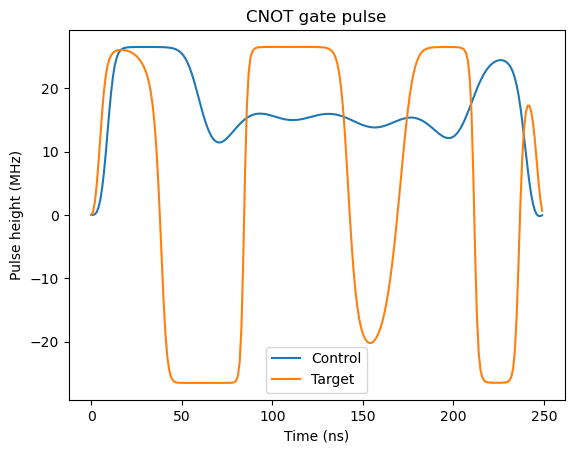

In [8]:
# Load the data from the text file, assuming the file is space-separated or tab-separated


# Replace 'your_file.txt' with the path to your actual file
data = np.loadtxt('F_0.9994044301600786_1amp_CNOT_n_ts_250_5_level.txt')

# Extract the last 4 columns
last_four_columns = 26.5*data[:, -2:]

# Print or return the resulting 2D numpy array
#print(np.array(last_four_columns))
plt.plot(last_four_columns[:,0],label="Control")
plt.plot(last_four_columns[:,1],label="Target")
plt.legend()
plt.xlabel("Time (ns)")
plt.ylabel("Pulse height (MHz)")
plt.title("CNOT gate pulse")
#dyn.initialize_controls(last_four_columns)
plt.savefig("Pulse1.png")

In [37]:
# everything is in units of MHz
f_1 = 5.03103*(10**3)
f_2 = 4.92672*(10**3)
f_3 = 5.03648*(10**3)
f_4 = 4.96961*(10**3)
f_5 = 4.83780*(10**3)
f_6 = 4.92466*(10**3)
delta_1 = -271
delta_2 = -269
delta_3 = -268
delta_4 = -269
delta_5 = -280
delta_6 = -271
# all the times (T) are in microseconds. Therefore, 1/T would be in MHz. [NOT INCLUDED rn.]
T1_1 = 44
T1_2 = 30
T1_3 = 25
T1_4 = 37
T1_5 = 1.6
T1_6 = 57
T2star_1 = 35
T2star_2 = 21
T2star_3 = 11
T2star_4 = 28
T2star_5 = 2.2
T2star_6 = 26
T2_1 = 40
T2_2 = 42
T2_3 = 27
T2_4 = 30
T2_5 = 2
T2_6 = 28


In [44]:
1/(1/T2_4-0.5/T1_4)

50.45454545454546

In [78]:
# no. of levels for each transmon.
N = 10
f_1 = 5.03103*(10**3)
f_2 = 4.92672*(10**3)
delta_1 = -271
delta_2 = -269
# the lists of variables for all 6 qubits.
f = [f_1, f_2] #the coefficient of the bare hamiltonian for each qubit
delta = [delta_1, delta_2] #the coefficient for the Kerr term
#      11    12     21    22
J = [[ 0.0, 4.03],[4.03, 0.0]]

# defines a_i.
a_1 = tensor(destroy(N), qeye(N))
a_2 = tensor(qeye(N), destroy(N))

a = [a_1, a_2]

# defines the identity matrix
identity_matrix = tensor(qeye(N), qeye(N))
# defines the zero matrix
zero_ = Qobj(np.zeros((N,N)))
zero_matrix = tensor(zero_, zero_)

def Hamiltonian(f, delta, J, N):
    
    # defines the bare Hamiltonian
    H_bare = zero_matrix
    for i in range(2):
        e = (f[i]-f[1])*(Qobj(a[i]).dag()*Qobj(a[i])) + 0.5*delta[i]*(Qobj(a[i]).dag()*Qobj(a[i]))*((Qobj(a[i]).dag()*Qobj(a[i])) - identity_matrix)
        H_bare = H_bare + (2*np.pi)*e
       
    # defines the interaction Hamiltonian (the spins are labelled 0-5)
    H_int = zero_matrix
    for i in range(2):
        # defines the interaction with the next neighbour on the right of the ith spin - which is the ((i+1) mod 6)-th spin..
        p_neighbor_1 = (J[i][(i + 1)%2])*(Qobj(a[i]).dag()*Qobj(a[(i+1)%2]) + Qobj(a[i])*Qobj(a[(i+1)%2]).dag())
        H_int = H_int + (2*np.pi)*0.5*(p_neighbor_1) #to prevent double counting, we need to multiply by 0.5.  
    
    #defines the full Hamiltonian
    Ham = H_bare + H_int
    return Ham

H_d = Hamiltonian(f, delta, J, N)
H_c = [ (2*np.pi)*Qobj(a[0].dag() + a[0])/2,(2*np.pi)*Qobj(a[1].dag() + a[1])/2]
n_ctrls = len(H_c)

# start point for the gate evolution
U_0 = identity_matrix
# Target for the gate evolution - Quantum Fourier Transform gate
from qutip.qip.operations import cnot
U_targ = cnot()#(tensor(identity(2),identity(2))-1j*tensor(sigmaz(),sigmax()))*(1/np.sqrt(2))
H_d


Quantum object: dims=[[10, 10], [10, 10]], shape=(100, 100), type='oper', dtype=Dense, isherm=True
Qobj data =
[[      0.               0.               0.         ...       0.
        0.               0.        ]
 [      0.               0.               0.         ...       0.
        0.               0.        ]
 [      0.               0.           -1690.17684763 ...       0.
        0.               0.        ]
 ...
 [      0.               0.               0.         ...  -90893.87812257
        0.               0.        ]
 [      0.               0.               0.         ...       0.
  -102725.11605599       0.        ]
 [      0.               0.               0.         ...       0.
        0.         -116246.53083704]]

In [79]:
from scipy.linalg import expm
U=identity(N**2)
H_c = [ 26.5*(2*np.pi)*Qobj(a[0].dag() + a[0])/(2),26.5*(2*np.pi)*Qobj(a[1].dag() + a[1])/2]
DECOH1=a[0]/np.sqrt(T1_1)+a[1]/np.sqrt(T1_2)
DECOH2=a[0].dag()*a[0]*np.sqrt((2/T2_1)-(1/T1_1))+a[1].dag()*a[1]*np.sqrt((2/T2_2)-(1/T1_2))
DS=1
U=Qobj(U.full(),dims=[[N,N],[N,N]])
fid=[]
for i in range(len(last_four_columns[:,1])):
    U=Qobj(expm(-0.001*1j*(H_d.full()+last_four_columns[i,0]*H_c[0].full()+last_four_columns[i,1]*H_c[1].full()+DS*DECOH1.full()+DS*DECOH2.full())),dims=[[N,N],[N,N]])*U
    U=Qobj(U.full(),dims=[[N,N],[N,N]])
U/U[0][0]

Quantum object: dims=[[10, 10], [10, 10]], shape=(100, 100), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j -2.10396948e-03-2.85565587e-02j
  -8.93385588e-03-4.74358184e-03j ... -3.41249629e-29-2.14555375e-29j
   2.63884547e-32+1.39293554e-32j -2.87655277e-33-1.42157981e-33j]
 [ 1.55845600e-03-2.75612903e-02j  9.94250566e-01-2.28960022e-03j
  -1.34728387e-03+3.69672696e-04j ... -6.53176154e-29-4.55620648e-29j
  -3.11426876e-32+4.85200927e-32j -4.88037827e-33-2.36553456e-33j]
 [ 6.12030055e-03-8.28062932e-03j  1.74246004e-03-6.19682834e-04j
   8.92833438e-01-4.44306633e-01j ...  4.63430938e-28+7.82593749e-28j
   5.85337736e-30+8.45407795e-31j  3.85982550e-32+8.02910675e-32j]
 ...
 [-1.04258008e-29+5.83968820e-30j -8.59180333e-30-1.03018616e-29j
  -9.57451613e-28+5.30208599e-31j ... -9.82001819e-01+1.44653895e-01j
   1.71755051e-03+2.17480236e-03j -3.18600510e-04-1.90452446e-04j]
 [ 4.95913166e-33-1.33941824e-31j  1.04628217e-31+4.79472705e-32j
  -1.

In [80]:
np.abs(U[0][0]+U[1][1]+U[N][N+1]+U[N+1][N])/4

0.9987855421025217

In [ ]:
99